In [127]:
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import *

In [5]:
%run ../paths.py 
CONST = CONST()

In [110]:
train = pd.read_csv("https://raw.githubusercontent.com/Sandhya-G/Aggression-Detection/master/dataset/GLOVE_TRAIN%23")
test = pd.read_csv("https://raw.githubusercontent.com/Sandhya-G/Aggression-Detection/master/dataset/GLOVE_TEST%23")

train.head()
train_x = train['tweet']
train_y = train['class']
test_x = test['tweet'].values
test_y = test['class'].values

(11949, 4)

In [20]:
%run ../src/processing/glove_utils.py
vocab = build_vocab(list(train_x.apply(lambda x:x.split())))
len(vocab)



41071

In [8]:
%run ../src/processing/glove_utils.py
glove_embed = load_embed(CONST.GLOVE_100d)

   

In [21]:
glove_embed['the']

array([ 9.5152e-02,  3.7024e-01,  5.4291e-01,  1.9621e-01,  4.8205e-02,
        3.2033e-01, -5.9638e-01,  1.5868e-02, -1.2989e-01, -6.3028e-01,
        8.1944e-02,  2.4164e-01, -6.0990e+00, -6.8557e-01,  5.0354e-01,
       -3.4089e-02,  1.1705e-01, -7.7403e-03, -8.6512e-02,  4.3617e-01,
       -4.3982e-01,  2.6125e-01, -4.0348e-02, -1.9194e-01,  8.3204e-02,
       -5.8246e-01, -3.1923e-02,  1.2630e-01,  4.0120e-01,  6.8906e-02,
       -1.0517e-01, -2.0804e-01, -4.2554e-01,  4.7799e-01,  3.4651e-01,
        2.4057e-01,  5.0244e-02, -7.2587e-02, -2.4347e-03, -5.0342e-01,
       -1.0601e+00, -3.1586e-01, -3.2457e-02, -7.6317e-02,  7.9045e-01,
        8.6367e-02, -1.9632e-01,  5.7566e-02,  8.4129e-01, -4.2020e-01,
       -1.1335e-03, -8.5632e-02,  6.1910e-02,  2.1423e-01, -1.0356e-01,
       -3.6946e-02, -2.6005e-01, -3.5657e-01,  5.4321e-02,  3.0875e-02,
        1.4092e-01, -9.1998e-02, -4.1841e-01, -3.1135e-01, -1.4937e-01,
       -2.2699e-04, -3.3454e-01, -1.4848e-01, -1.1944e-01, -2.71

In [13]:
#train['total_length'].median()

In [19]:
train['total_length'].mean()

43.445371162437034

In [24]:
train['total_length'].max()

277

In [33]:
df = train[train['total_length']<100]
print(df['tweet'].count())

41092


In [22]:
MAX_SEQ_LEN = 100
MAX_NUM_WORDS = 20000
EMBED_DIM = 100




In [23]:
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer.fit_on_texts(list(train_x) + list(test_x))
print(len(tokenizer.word_index))
print("Word index:",tokenizer.word_index)


train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)


47577
Word index: {'hashtag': 1, 'user': 2, 'the': 3, 'i': 4, 'a': 5, 'you': 6, 'to': 7, 'is': 8, 'and': 9, 'bitch': 10, 'my': 11, 'not': 12, 'in': 13, 'of': 14, 'for': 15, 'it': 16, 'that': 17, 'on': 18, 'this': 19, 'be': 20, 'allcaps': 21, 'me': 22, 'are': 23, 'with': 24, 'do': 25, 'am': 26, 'all': 27, 'like': 28, 'out': 29, 'so': 30, 'have': 31, 'bitches': 32, 'love': 33, 'your': 34, 'just': 35, 'at': 36, 'day': 37, 'but': 38, 'when': 39, 'up': 40, 'hoes': 41, 'we': 42, 'will': 43, 'they': 44, 'get': 45, 'what': 46, 'pussy': 47, 'was': 48, 'no': 49, 'if': 50, 'ass': 51, 'hoe': 52, 'got': 53, 'happy': 54, 'about': 55, 'fuck': 56, 'he': 57, 'she': 58, 'these': 59, 'from': 60, 'her': 61, 'can': 62, 'now': 63, 'smile': 64, 'as': 65, 'one': 66, 'how': 67, 'life': 68, 'shit': 69, 'who': 70, 'laughing': 71, 'cannot': 72, 'good': 73, 'loud': 74, 'some': 75, 'people': 76, 'go': 77, 'new': 78, 'time': 79, 'off': 80, 'nigga': 81, 'know': 82, 'see': 83, 'by': 84, 'today': 85, 'or': 86, 'trash':

In [76]:

#default is pre-padding, can try with post paddding
train_X = pad_sequences(train_x, maxlen = MAX_SEQ_LEN)
test_X = pad_sequences(test_x, maxlen = MAX_SEQ_LEN)


In [25]:

#prepare the embedding matrix

num_words = MAX_NUM_WORDS
embedding_matrix = np.zeros((num_words, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = glove_embed.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [26]:
embedding_matrix.shape

(20000, 100)

In [33]:
#deep learning imports

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D , Dense , Dropout, concatenate , Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from numpy import random
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [114]:



class textCNN:
    def __init__(self,sequence_len, max_words, no_classes, embed_dim, filter_size,no_filters,hidden_dims,drop_rate):
        self.sequence_len = sequence_len
        self.max_words = max_words
        self.no_classes = no_classes
        self.embed_dim = embed_dim
        self.filter_size = filter_size
        self.no_filters = no_filters
        self.hidden_dims = hidden_dims
        self.drop_rate = drop_rate


    def cnn_model(self):
        inp = Input(shape = (self.sequence_len,) , name = 'inp')
        embed = Embedding(self.max_words, self.embed_dim, weights = [embedding_matrix], input_length = self.sequence_len ,trainable = False  )(inp)
       
        #keep low drop out rate for input
        embed = Dropout(0.2)(embed)
                
        x = self.conv_layer(embed)
        x = Activation('relu')(x)
        output = Dense(1, activation='sigmoid')(x)
        return Model(inputs = inp, outputs = output)

    
 
    
    def conv_layer(self, embed): 
        conv_channels = []
        for i in range(len(self.filter_size)):
            channel = self.each_conv_channel(embed, self.no_filters, self.filter_size[i])
            conv_channels.append(channel)
            if (len(conv_channels)>1):                
                channel = keras.layers.concatenate(conv_channels)
        
        return channel
        
    def each_conv_channel(self, embed, no_filters, filter_size):
        x = Conv1D(no_filters, kernel_size = filter_size, activation = 'relu', strides=1, padding='valid')(embed)
        x = GlobalMaxPooling1D()(x)
            #hidden dense layer
        x = Dense(self.hidden_dims)(x)
        x = Dropout(self.drop_rate)(x)
        return x
        
    
    

In [115]:
model1 = fit_eval()

In [116]:
model1

# CLR 

In [70]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K
import numpy as np


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.learning_rate, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])[0]
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]


In [117]:
lr_finder = LRFinder(model1)


In [118]:
lr_finder.find(train_X, train_y, start_lr=0.0001, end_lr=1, batch_size=256, epochs=5)


Epoch 1/5
42701/42701 [==============================] - 39s 914us/step - loss: 0.6797 - accuracy: 0.6381
Epoch 2/5
42701/42701 [==============================] - 38s 893us/step - loss: 0.3239 - accuracy: 0.8725
Epoch 3/5
42701/42701 [==============================] - 37s 876us/step - loss: 0.2310 - accuracy: 0.9175
Epoch 4/5
41984/42701 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8819

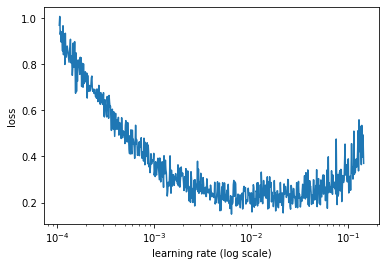

In [119]:
lr_finder.plot_loss(n_skip_beginning=5, n_skip_end=5)


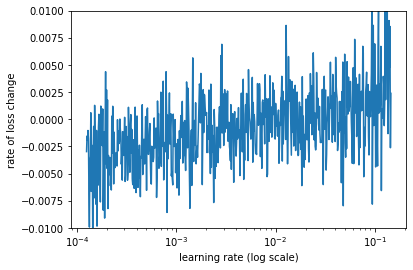

In [120]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.01, 0.01))

In [128]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

      
        for k, v in logs.items():
          self.history.setdefault(k, []).append(v)
        
        K.set_value(model.optimizer.lr, self.clr())

In [130]:
iterations = len(train_y)/512
step_size = math.floor(iterations*2)
step_size

166

In [132]:
clr = CyclicLR(base_lr=0.001, max_lr=0.03,step_size=step_size)
early_stop = EarlyStopping(monitor='val_loss', patience = 1, verbose = 1) 
checkpoint = ModelCheckpoint('cnn.h5',monitor='val_loss', verbose=1, save_best_only=True)

In [133]:
history = model1.fit(train_X, train_y,validation_data=(val_X, val_y),callbacks=[clr],batch_size=512,verbose=1,epochs=4)

NameError: name 'val_X' is not defined

Model training with 2 fold cross validation

In [88]:
#from textCNN import textCNN

#deep learning parameters
filter_sizes = [3,4,5]
num_filters = 10
dropout_rate = 0.7
hidden_dense_units = 20


#training parameters
no_folds = 1
batch_size = 100
epochs = 4 
#lr = 0.001


#train_X test_X train_y test_y

model_history = []




#model_checkpoint = ModelCheckpoint('cnn_text.h5',monitor='val_loss', verbose=1, save_best_only=True)
def fit_eval(tr_x=None, val_x=None, tr_y=None, val_y=None,isFit=False):
    model= None
    model = textCNN(    
    sequence_len = MAX_SEQ_LEN,
    max_words = MAX_NUM_WORDS,
    no_classes = 2,
    embed_dim = EMBED_DIM,
    filter_size = filter_sizes,
    no_filters = num_filters,
    hidden_dims = hidden_dense_units,
    drop_rate = dropout_rate    
    ).cnn_model()
    
    #model.summary()
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    if isFit:
        result = model.fit(tr_x, tr_y, epochs = epochs, batch_size = batch_size, callbacks = [EarlyStopping(monitor='loss', patience = 3, verbose = 1) , ModelCheckpoint('cnn_text.h5',monitor='loss', verbose=1, save_best_only=True)], 
              verbose=1 , validation_data=(val_x, val_y))  
        print("Val Score: ", model.evaluate(val_x, val_y))
        return result
    else :
        return model
    
    
for i in range(no_folds):
    print("Training on fold ",i+1)
    tr_x, val_x, tr_y, val_y = train_test_split(train_X, tf.keras.utils.to_categorical(train_y), test_size = 0.1, random_state = np.random.randint(1,1000))
    model_history.append(fit_eval(tr_x, val_x, tr_y, val_y,True))
    



    
   

Training on fold  1
Train on 38430 samples, validate on 4271 samples
Epoch 1/4
38430/38430 [==============================] - 35s 923us/step - loss: 0.3956 - accuracy: 0.8320 - val_loss: 0.2132 - val_accuracy: 0.9197

Epoch 00001: loss improved from inf to 0.39560, saving model to cnn_text.h5
Epoch 2/4
38430/38430 [==============================] - 38s 1000us/step - loss: 0.2322 - accuracy: 0.9153 - val_loss: 0.1889 - val_accuracy: 0.9265

Epoch 00002: loss improved from 0.39560 to 0.23224, saving model to cnn_text.h5
Epoch 3/4
38430/38430 [==============================] - 39s 1ms/step - loss: 0.2169 - accuracy: 0.9208 - val_loss: 0.1870 - val_accuracy: 0.9279

Epoch 00003: loss improved from 0.23224 to 0.21692, saving model to cnn_text.h5
Epoch 4/4
38430/38430 [==============================] - 34s 894us/step - loss: 0.2091 - accuracy: 0.9238 - val_loss: 0.1814 - val_accuracy: 0.9333

Epoch 00004: loss improved from 0.21692 to 0.20912, saving model to cnn_text.h5
4271/4271 [=========

In [39]:
model_history[0].history

{'val_loss': [0.18593801673151966,
  0.16615913026130777,
  0.15939498953721865,
  0.15664150302100588,
  0.15210571920695892],
 'val_accuracy': [0.9335050582885742,
  0.938421905040741,
  0.9431046843528748,
  0.947553277015686,
  0.9496604800224304],
 'loss': [0.3111102478387236,
  0.18148404894134448,
  0.1492664818842213,
  0.13122265710127778,
  0.11501048968859151],
 'accuracy': [0.87142855, 0.93419206, 0.9464481, 0.95422846, 0.96031743]}

evaluate model

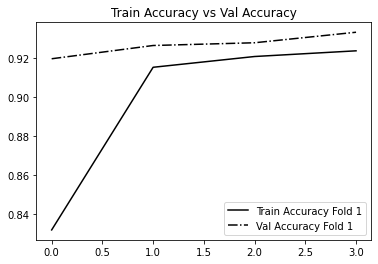

In [91]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.legend()
plt.show()  


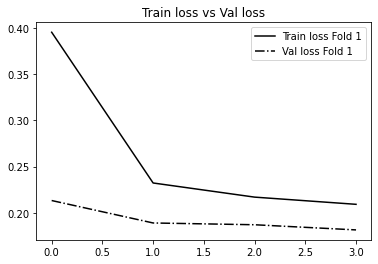

In [92]:
plt.title('Train loss vs Val loss')
plt.plot(model_history[0].history['loss'], label='Train loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val loss Fold 1', color='black', linestyle = "dashdot")
plt.legend()
plt.show()  

In [93]:
from sklearn import metrics

Test

In [94]:
model = load_model('cnn_text.h5')
pred = model.predict(test_X)
y_hat = pred.argmax(axis=-1)
print(metrics.classification_report(test_y, y_hat))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6968
           1       0.94      0.91      0.92      4981

    accuracy                           0.94     11949
   macro avg       0.94      0.93      0.93     11949
weighted avg       0.94      0.94      0.94     11949



In [95]:
model = load_model('cnn_text.h5')
print(model.evaluate(test_X, tf.keras.utils.to_categorical(test_y), verbose = 1))

11949/11949 [==============================] - 3s 264us/step
[0.15995898283753038, 0.9367311000823975]


In [96]:
auc = roc_auc_score(tf.keras.utils.to_categorical(test_y), pred.round() )
print('ROC AUC: %f' % auc)

ROC AUC: 0.932699


In [97]:


def predict_result(text):
  val = tokenizer.texts_to_sequences([text])
  val = pad_sequences(val, maxlen=100,padding='post',truncating='post')
  return model.predict(val)[0]



In [98]:
predict_result("That is fucking awesome")[0]

0.92106926